# Финальный проект. 
# Оптимизация потребления электроэнергии на этапе обработки стали


**Задача проекта:**
- Уменьшить потребление электроэнергии на этапе обработки стали; 
- Построить модель, которая предскажет температуру стали.

 **Описание этапа обработки стали**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**План работы**
1. Подготовить данные:
- привести название столбцов к единому формату; +
- изменить типы данных столбцов, содержащих значения времени; +
- объединить таблицы data_arc и data_temp и установить для каждой партии соответствие времени и температуры. Удалить строки, не имеющие финального замера температуры и строки содержащие только одно измерение.
- соединить полученную таблицу с данными о подаче материалов и продувке газом.

- для каждой партии необходимо определить суммарные электрические мощности(активную и реактивную)


2. Подготовить данные к обучению:
- определить признаки и целевой признак;
- разделить данные на обучающую и тестовую выборки в соотношении 3:1. 

3. Обучить модели используя модели регресии:
- LightGBM;
- LinearRegression;
- DecisionRegressor.

4. Протестировать лучшую модель на тестовой выборке.

5. Подготовить итоговый отчет.

##  Подготовка данных к обучению

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#импортируем необходимые библиотеки
#импорты из стандартной библиотеки
import pandas as pd 

import numpy as np

import matplotlib.pyplot as plt 

import seaborn as sns

import warnings

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor

In [ ]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv',parse_dates=[1,2]) 
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])  
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')  
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv') 
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1]) 
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv') 
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates=[1,2,3,4,5,6,7,8,9]) 
except:
    data_arc = pd.read_csv('/content/gdrive/MyDrive/data_arc.csv',parse_dates=[1,2]) #данные об электродах
    data_bulk = pd.read_csv('/content/gdrive/MyDrive/data_bulk.csv')  #данные о подаче сыпучих материалов (объём)
    data_bulk_time = pd.read_csv('/content/gdrive/MyDrive/data_bulk_time.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])  #данные о подаче сыпучих материалов (время)
    data_gas = pd.read_csv('/content/gdrive/MyDrive/data_gas.csv') #данные о продувке сплава газом
    data_temp = pd.read_csv('/content/gdrive/MyDrive/data_temp.csv', parse_dates=[1]) #результаты измерения температуры
    data_wire = pd.read_csv('/content/gdrive/MyDrive/data_wire.csv') #данные о проволочных материалах (объём)
    data_wire_time = pd.read_csv('/content/gdrive/MyDrive/data_wire_time.csv', parse_dates=[1,2,3,4,5,6,7,8,9]) #данные о проволочных материалах (время)

In [ ]:
#изучим данные воспользовавшись унифицированной функцией
def uni_function(function):
    display(function.head())
    display(function.info())
    display(function.isna().mean().sort_values(ascending = True)) #доля пропущенных значений
    display(function.describe())
    display(function.duplicated().sum())

###  Данные об электродах

In [ ]:
display(uni_function(data_arc)) 

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


0

None

In [ ]:
#откорректируем названия столбцов
data_arc = data_arc.rename(columns={'Начало нагрева дугой': 'start_time',
                                    'Конец нагрева дугой': 'end_time',
                                    'Активная мощность': 'active_power',
                                    'Реактивная мощность': 'reactive_power'})

In [ ]:
#определим уникальные значения в столбце key
data_arc['key'].value_counts()

2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: key, Length: 3214, dtype: int64

Как мы видим, в столбце реактивная мощность есть выбросы в виде отрицательных значений. Для определения выбросов воспользуемся диаграммой размаха.

(-720.0, 5.0)

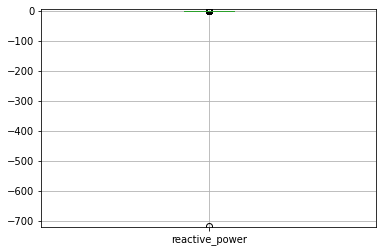

In [ ]:
#постороим диаграмму размаха для определения выбросов
data_arc.boxplot(column='reactive_power')
plt.ylim(-720, 5)

In [ ]:
#определим верхнюю границу значений, которые не являются выбросами (правый ус)
Q3 = data_arc['reactive_power'].describe()['75%'] #Третий квартиль
Q1 = data_arc['reactive_power'].describe()['25%'] #Первый квартиль 
IQR = Q3-Q1 #Межквартильный размах 
right_mustache = Q3 + 1.5*IQR #правый ус
left_mustache = Q1 - 1.5*IQR #левый ус
print(right_mustache)
print(left_mustache)

1.1569404714625
-0.2285784670375


In [ ]:
data_arc_filt = data_arc[(data_arc['reactive_power'] <=  right_mustache) & (data_arc['reactive_power']>= left_mustache)]

In [ ]:
#рассмотрим как изменились показатели 
display(data_arc.describe()) #начальный датасет
display(data_arc_filt.describe())

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,active_power,reactive_power
count,14275.000000,14275.000000,14275.000000
mean,1612.567285,0.621222,0.460584
std,934.450941,0.325278,0.240700
min,1.000000,0.030002,0.020806
25%,805.000000,0.388195,0.284188
50%,1608.000000,0.540310,0.403195
75%,2429.000000,0.810810,0.603689
max,3241.000000,2.019616,1.156689


In [ ]:
#определим долю удаленных значений
remote_values = (data_arc.shape[0] - data_arc_filt.shape[0])/data_arc.shape[0] * 100
display(remote_values)

4.040064533476741

При удалении выбросов в столбце reactive_power мы потеряем чуть больше 4 процентов. Потеря такого количества данных существенно не повлияет на наше исследование. Однако, данные выбросы являются частью реального технологического процесса и он важны для данного исследования. 

Данные сохраняем в неизменном виде, однако, для наглядности, при построении гистограммы со значениями реактивных мощностей, воспользуемся отфильтрованным датафреймом.

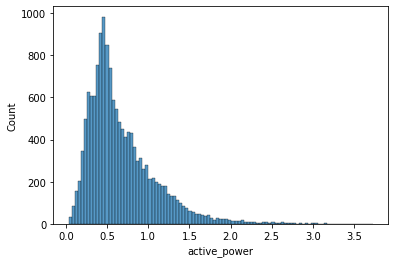

In [ ]:
sns.histplot(data=data_arc, x='active_power')

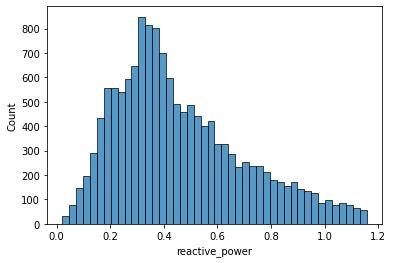

In [ ]:
sns.histplot(data=data_arc_filt, x='reactive_power')

**Вывод по разделу 1.1**
1. Названия столбцов не имели единый стиль. Имена столбцов переименованы в сответствии с общепринятыми рекомендациями:
- имя выражает смысл переменной;
- использовались английские слова;
-	в имени используют только строчные буквы.
2. Столбцы, содержащие информацию о времени, имели неверный формат. Тип данных был откорректирован в формат date64.
3. В таблице с данными наблюдаются аномальные значения реактивной можности. Для более точной оценки была построена диаграмма размаха.
4. Таблица с данными имеются строки с повторяющимся значением номера партии.
5. Пропуски отсутствуют.


###  Данные о подаче сыпучих материалов (объём)

In [ ]:
display(uni_function(data_bulk)) 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key        0.000000
Bulk 14    0.103228
Bulk 12    0.217002
Bulk 15    0.281560
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 6     0.815916
Bulk 1     0.919463
Bulk 11    0.943432
Bulk 10    0.943752
Bulk 5     0.975391
Bulk 7     0.992010
Bulk 2     0.992969
Bulk 9     0.993928
Bulk 13    0.994247
Bulk 8     0.999680
dtype: float64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


0

None

In [ ]:
data_bulk.columns = data_bulk.columns.str.lower()
#display(data_bulk.head())

In [ ]:
#откорректируем названия столбцов
data_bulk = data_bulk.rename(columns={'bulk 1': 'bulk_1',
                                    'bulk 2': 'bulk_2',
                                    'bulk 3': 'bulk_3',
                                    'bulk 4': 'bulk_4',
                                    'bulk 5': 'bulk_5',
                                    'bulk 6': 'bulk_6',
                                    'bulk 7': 'bulk_7',
                                    'bulk 8': 'bulk_8',
                                    'bulk 9': 'bulk_9',
                                    'bulk 10': 'bulk_10',
                                    'bulk 11': 'bulk_11',
                                    'bulk 12': 'bulk_12',
                                    'bulk 13': 'bulk_13',
                                    'bulk 14': 'bulk_14',
                                    'bulk 15': 'bulk_15'})

Для наглядности построим диаграммы для каждого этапа подачи материалов.

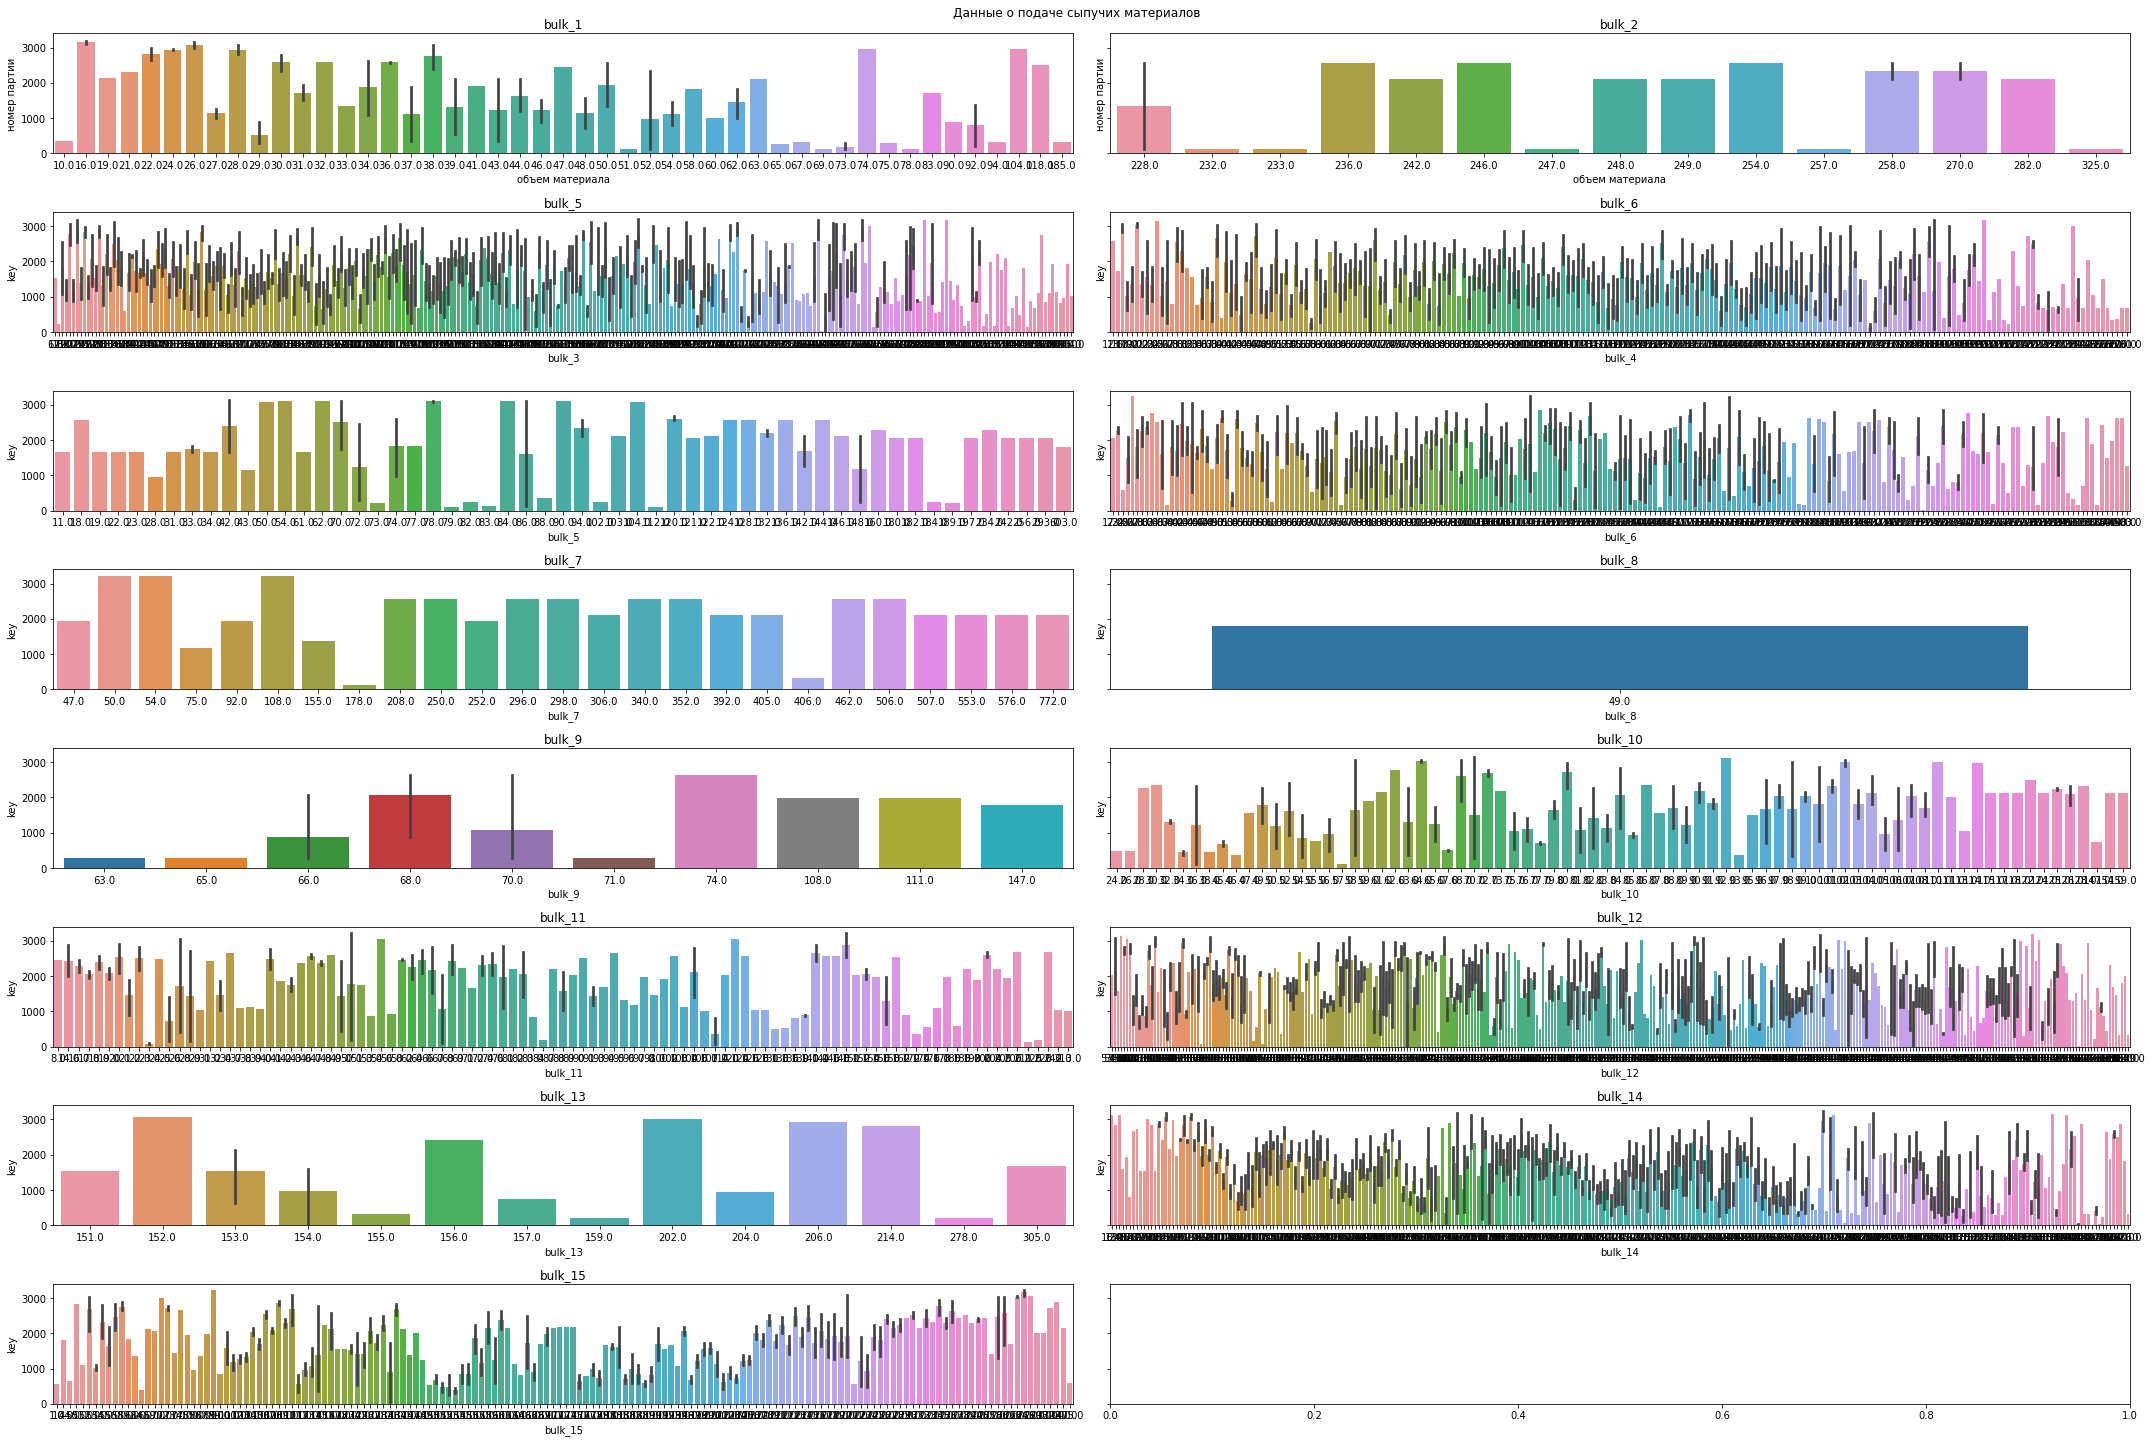

In [ ]:
fig, axes = plt.subplots(8, 2, figsize=(30, 20), sharey=True)
fig.suptitle('Данные о подаче сыпучих материалов', y=1)

# bulk_1
sns.barplot(ax=axes[0,0], data = data_bulk, x='bulk_1', y='key')
axes[0,0].set_title('bulk_1')
axes[0,0].set_xlabel('объем материала')
axes[0,0].set_ylabel('номер партии')
plt.tight_layout()

# bulk_2
sns.barplot(ax=axes[0,1], data = data_bulk, x='bulk_2', y='key')
axes[0,1].set_title('bulk_2')
axes[0,1].set_xlabel('объем материала')
axes[0,1].set_ylabel('номер партии')
plt.tight_layout()

# bulk_3
sns.barplot(ax=axes[1,0], data = data_bulk, x='bulk_3', y='key')
axes[1,0].set_title('bulk_3')
plt.tight_layout()

# bulk_4
sns.barplot(ax=axes[1,1], data = data_bulk, x='bulk_4', y='key')
axes[1,1].set_title('bulk_4')
plt.tight_layout()

# bulk_5
sns.barplot(ax=axes[2,0], data = data_bulk, x='bulk_5', y='key')
axes[1,0].set_title('bulk_5')
plt.tight_layout()

# bulk_6
sns.barplot(ax=axes[2,1], data = data_bulk, x='bulk_6', y='key')
axes[1,1].set_title('bulk_6')
plt.tight_layout()

# bulk_7
sns.barplot(ax=axes[3,0], data = data_bulk, x='bulk_7', y='key')
axes[3,0].set_title('bulk_7')
plt.tight_layout()

# bulk_8
sns.barplot(ax=axes[3,1], data = data_bulk, x='bulk_8', y='key')
axes[3,1].set_title('bulk_8')
plt.tight_layout()

# bulk_9
sns.barplot(ax=axes[4,0], data = data_bulk, x='bulk_9', y='key')
axes[4,0].set_title('bulk_9')
plt.tight_layout()

# bulk_10
sns.barplot(ax=axes[4,1], data = data_bulk, x='bulk_10', y='key')
axes[4,1].set_title('bulk_10')
plt.tight_layout()

# bulk_11
sns.barplot(ax=axes[5,0], data = data_bulk, x='bulk_11', y='key')
axes[5,0].set_title('bulk_11')
plt.tight_layout()

# bulk_12
sns.barplot(ax=axes[5,1], data = data_bulk, x='bulk_12', y='key')
axes[5,1].set_title('bulk_12')
plt.tight_layout()

# bulk_13
sns.barplot(ax=axes[6,0], data = data_bulk, x='bulk_13', y='key')
axes[6,0].set_title('bulk_13')
plt.tight_layout()

# bulk_14
sns.barplot(ax=axes[6,1], data = data_bulk, x='bulk_14', y='key')
axes[6,1].set_title('bulk_14')
plt.tight_layout()

# bulk_15
sns.barplot(ax=axes[7,0], data = data_bulk, x='bulk_15', y='key')
axes[7,0].set_title('bulk_15')
plt.tight_layout()

Bulk 8     0.999680
Bulk 13    0.994247
Bulk 9     0.993928
Bulk 2     0.992969
Bulk 7     0.992010
Bulk 5     0.975391
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 1     0.919463
Bulk 6     0.815916
Bulk 4     0.675935
Bulk 3     0.585171
Bulk 15    0.281560
Bulk 12    0.217002
Bulk 14    0.103228
key        0.000000

**Вывод по разделу 1.2**
1.  Названия столбцов не имели единый стиль. Поэтому: 
- переменные были приведены к нижнему регистру;
- вместо пробелов используется нижнее подчеркивание.
2. Присутствую пропуски. Это может быть связано с ошибкой в работе датчика или на данной стадии замер не проводился.
3. Для наглядности данных, были построены гистограммы, для каждого этапа подачи материалов. Графики отражают таблицу с показателями пропусков.


###  Данные о подаче сыпучих материалов (время)

In [ ]:
 display(uni_function(data_bulk_time))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

key        0.000000
Bulk 14    0.103228
Bulk 12    0.217002
Bulk 15    0.281560
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 6     0.815916
Bulk 1     0.919463
Bulk 11    0.943432
Bulk 10    0.943752
Bulk 5     0.975391
Bulk 7     0.992010
Bulk 2     0.992969
Bulk 9     0.993928
Bulk 13    0.994247
Bulk 8     0.999680
dtype: float64

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


0

None

In [ ]:
data_bulk_time.columns = data_bulk.columns.str.lower()

In [ ]:
#откорректируем названия столбцов
data_bulk_time = data_bulk_time.rename(columns={'bulk 1': 'bulk_1',
                                    'bulk 2': 'bulk_2',
                                    'bulk 3': 'bulk_3',
                                    'bulk 4': 'bulk_4',
                                    'bulk 5': 'bulk_5',
                                    'bulk 6': 'bulk_6',
                                    'bulk 7': 'bulk_7',
                                    'bulk 8': 'bulk_8',
                                    'bulk 9': 'bulk_9',
                                    'bulk 10': 'bulk_10',
                                    'bulk 11': 'bulk_11',
                                    'bulk 12': 'bulk_12',
                                    'bulk 13': 'bulk_13',
                                    'bulk 14': 'bulk_14',
                                    'bulk 15': 'bulk_15'})

**Вывод по разделу 1.3**

1. Названия столбцов не имели единый стиль. Поэтому: 
- переменные были приведены к нижнему регистру;
- вместо пробелов используется нижнее подчеркивание.
2. Присутствую пропуски. Это может быть связано с ошибкой в работе датчика или на данной стадии замер не проводился.
3. Столбцы, содержащие информацию о времени, имели неверный формат. Тип данных был откорректирован в формат date64. 

### Данные о продувке сплава газом

In [ ]:
display(uni_function(data_gas))

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0.0
Газ 1    0.0
dtype: float64

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


0

None

In [ ]:
#откорректируем названия столбцов
data_gas = data_gas.rename(columns={'Газ 1': 'gas'})

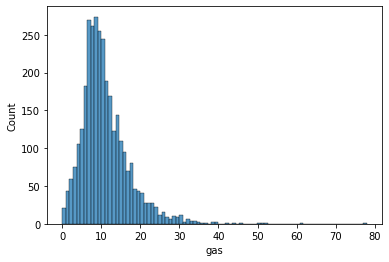

In [ ]:
#построим гистограмму
sns.histplot(data=data_gas, x='gas')

**Вывод по разделу 1.4**

1. Названия столбцов не имели единый стиль. Имя столбца  "Газ 1" переименовано в сответствии с общепринятыми рекомендациями:
- имя выражает смысл переменной;
- использовались английские слова;
-	в имени используют только строчные буквы.
2. Пропущенных значений нет.
3. Для наглядности построена гистограмма по данным столбца "gas".

### Результаты измерения температуры

In [ ]:
display(uni_function(data_temp))

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

key             0.000000
Время замера    0.000000
Температура     0.182373
dtype: float64

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


0

None

In [ ]:
#откорректируем названия столбцов
data_temp = data_temp.rename(columns={'Время замера': 'measurement_time',
                                    'Температура': 'measurement_temp'})

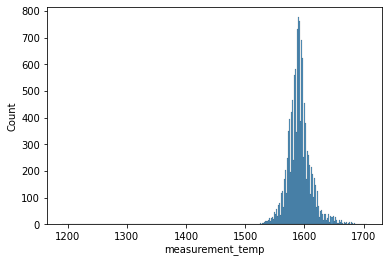

In [ ]:
#построим гистограмму
sns.histplot(data=data_temp, x='measurement_temp')

**Вывод по разделу 1.5**
1. Названия столбцов не имели единый стиль. Имена столбцов переименованы в сответствии с общепринятыми рекомендациями:
- имя выражает смысл переменной;
- использовались английские слова;
-	в имени используют только строчные буквы.
2. Столбцы, содержащие информацию о времени, имели неверный формат. Тип данных был откорректирован в формат date64.
3. В таблице с данными наблюдаются аномальные значения реактивной можности. Для более точной оценки была построена диаграмма размаха.
4. Таблица с данными имеются строки с повторяющимся значением номера партии.
5. Присутствуют пропуски в столбце "measurement_temp".
6. Для наглядности представления информации построена гистограмма по значениям столбца "measurement_temp".

### Данные о проволочных материалах (объём)

In [ ]:
display(uni_function(data_wire))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 6    0.976306
Wire 3    0.979552
Wire 9    0.990587
Wire 8    0.993833
Wire 4    0.995456
Wire 7    0.996430
Wire 5    0.999675
dtype: float64

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


0

None

In [ ]:
data_wire.columns = data_wire.columns.str.lower()

In [ ]:
#откорректируем названия столбцов
data_wire = data_wire.rename(columns={'wire 1': 'wire_1',
                                    'wire 2': 'wire_2',
                                    'wire 3': 'wire_3',
                                    'wire 4': 'wire_4',
                                    'wire 5': 'wire_5',
                                    'wire 6': 'wire_6',
                                    'wire 7': 'wire_7',
                                    'wire 8': 'wire_8',
                                    'wire 9': 'wire_9'})

In [ ]:
#display(data_wire.head())

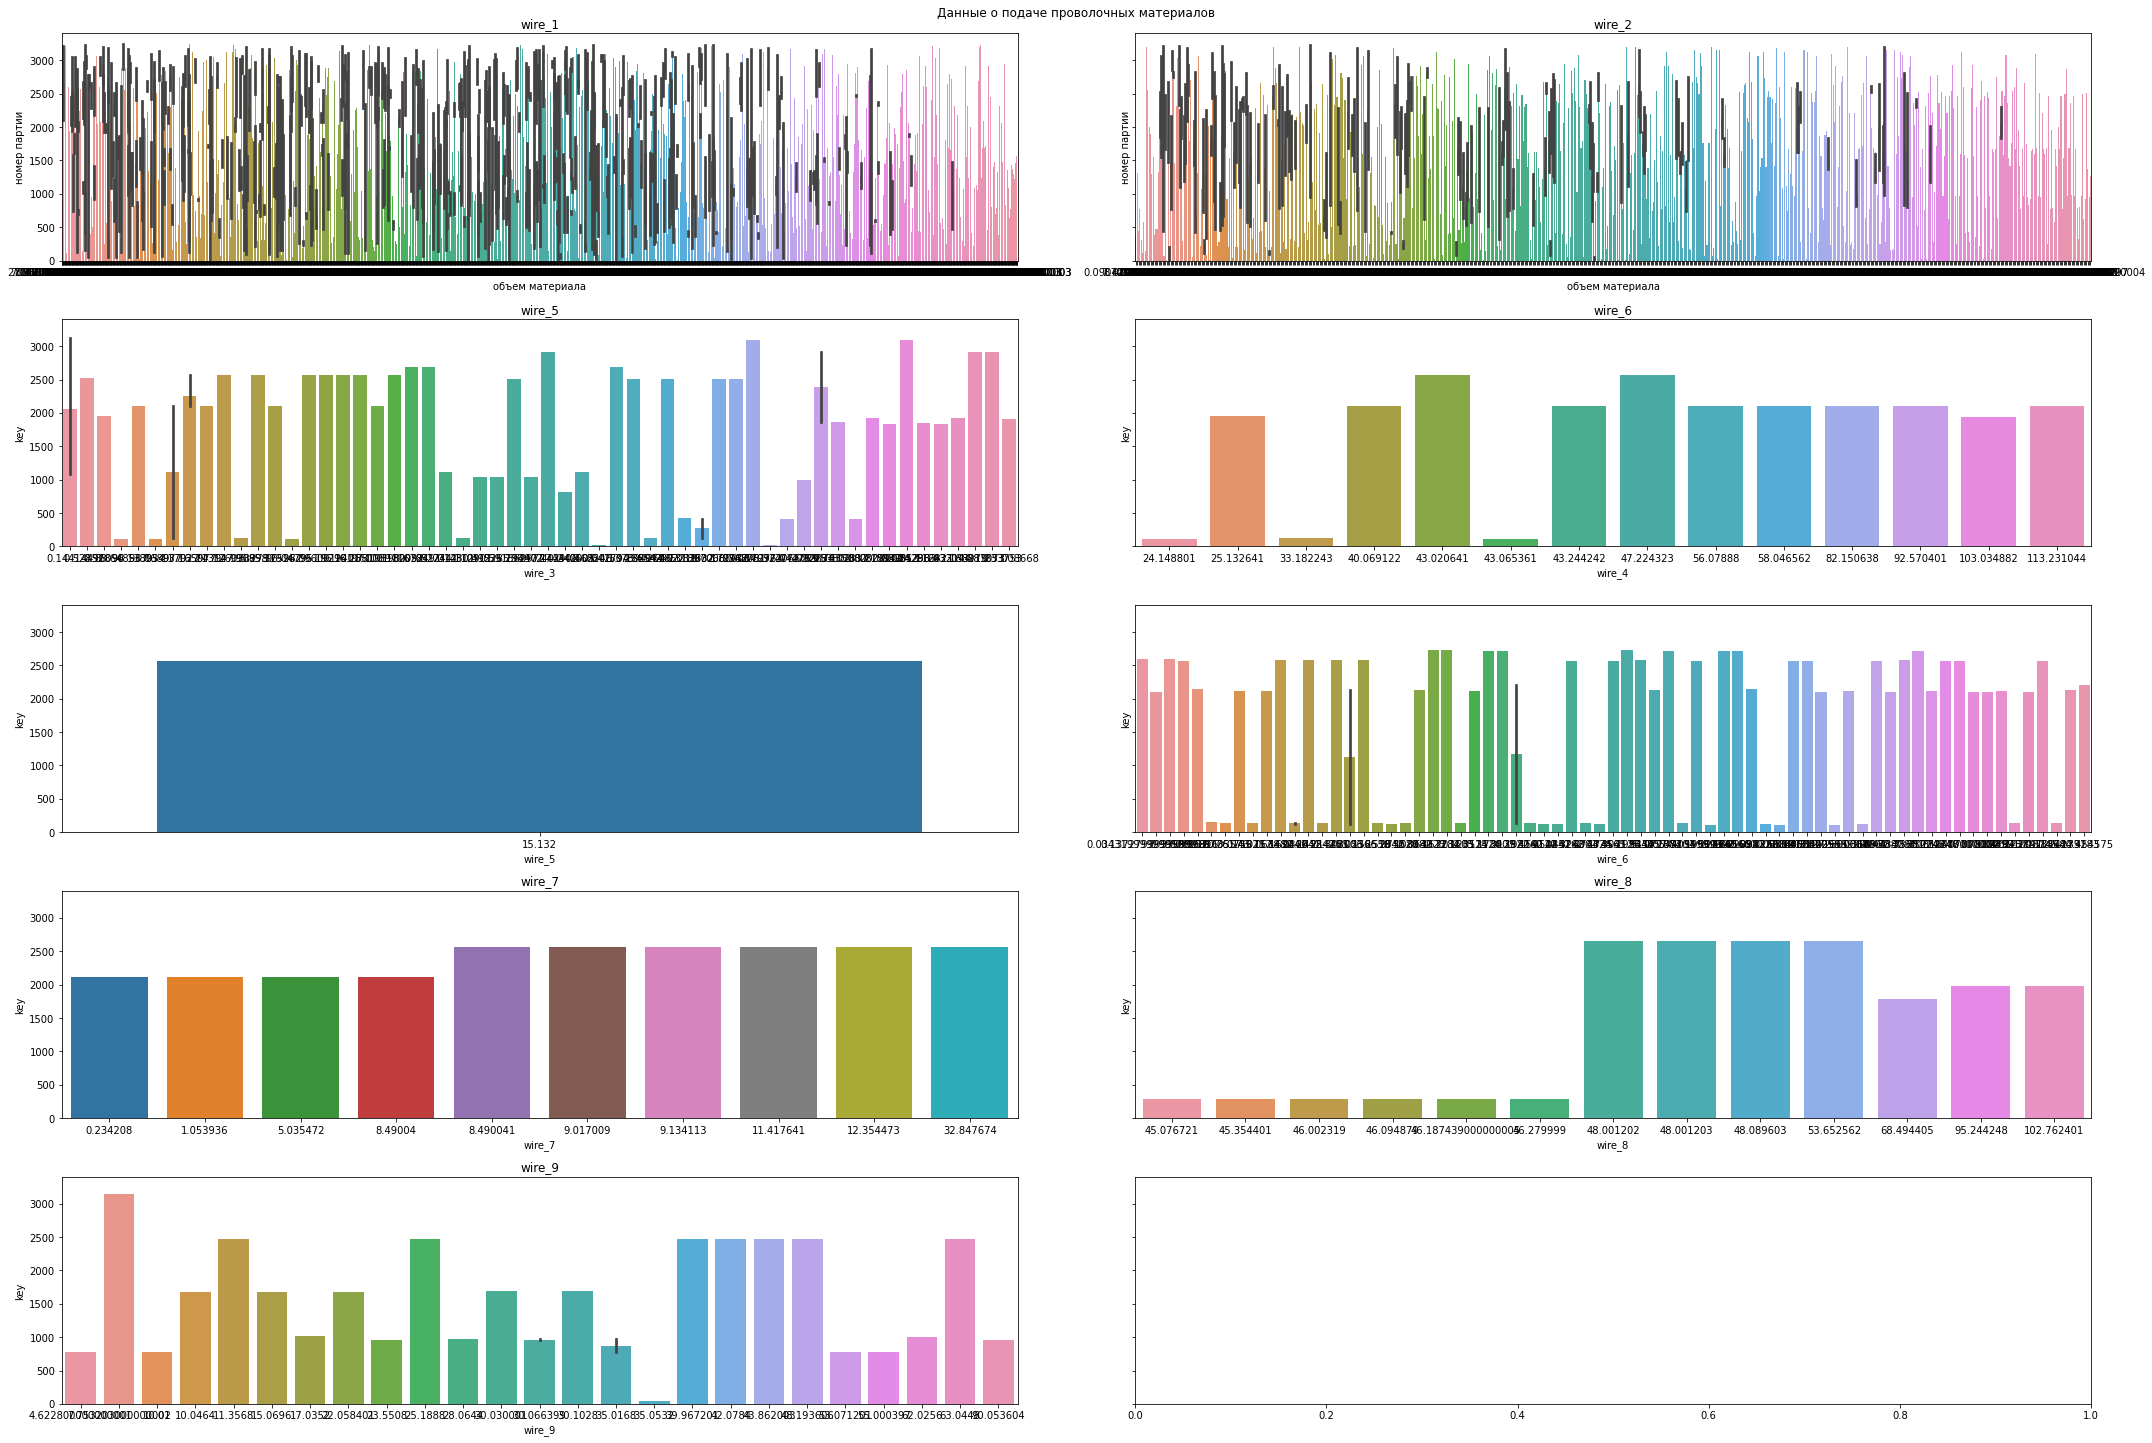

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(30, 20), sharey=True)
fig.suptitle('Данные о подаче проволочных материалов', y=1)

# wire_1
sns.barplot(ax=axes[0,0], data = data_wire, x='wire_1', y='key')
axes[0,0].set_title('wire_1')
axes[0,0].set_xlabel('объем материала')
axes[0,0].set_ylabel('номер партии')
plt.tight_layout()

# wire_2
sns.barplot(ax=axes[0,1], data = data_wire, x='wire_2', y='key')
axes[0,1].set_title('wire_2')
axes[0,1].set_xlabel('объем материала')
axes[0,1].set_ylabel('номер партии')
plt.tight_layout()

# wire_3
sns.barplot(ax=axes[1,0], data = data_wire, x='wire_3', y='key')
axes[1,0].set_title('wire_3')
plt.tight_layout()

# wire_4
sns.barplot(ax=axes[1,1], data = data_wire, x='wire_4', y='key')
axes[1,1].set_title('wire_4')
plt.tight_layout()

# wire_5
sns.barplot(ax=axes[2,0], data = data_wire, x='wire_5', y='key')
axes[1,0].set_title('wire_5')
plt.tight_layout()

# wire_6
sns.barplot(ax=axes[2,1], data = data_wire, x='wire_6', y='key')
axes[1,1].set_title('wire_6')
plt.tight_layout()

# wire_7
sns.barplot(ax=axes[3,0], data = data_wire, x='wire_7', y='key')
axes[3,0].set_title('wire_7')
plt.tight_layout()

# wire_8
sns.barplot(ax=axes[3,1], data = data_wire, x='wire_8', y='key')
axes[3,1].set_title('wire_8')
plt.tight_layout()

# wire_9
sns.barplot(ax=axes[4,0], data = data_wire, x='wire_9', y='key')
axes[4,0].set_title('wire_9')
plt.tight_layout()


**Вывод по разделу 1.6**
1.  Названия столбцов не имели единый стиль. Поэтому: 
- переменные были приведены к нижнему регистру;
- вместо пробелов используется нижнее подчеркивание.
2. Присутствую пропуски. Это может быть связано с ошибкой в работе датчика или на данной стадии замер не проводился.
3. Для наглядности данных, были построены гистограммы, для каждого этапа подачи материалов. Графики отражают таблицу с показателями пропусков.

### Данные о проволочных материалах (время)

In [ ]:
display(uni_function(data_wire_time))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 6    0.976306
Wire 3    0.979552
Wire 9    0.990587
Wire 8    0.993833
Wire 4    0.995456
Wire 7    0.996430
Wire 5    0.999675
dtype: float64

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


0

None

In [ ]:
data_wire_time.columns = data_wire.columns.str.lower()

In [ ]:
#откорректируем названия столбцов
data_wire_time = data_wire_time.rename(columns={'wire 1': 'wire_1',
                                    'wire 2': 'wire_2',
                                    'wire 3': 'wire_3',
                                    'wire 4': 'wire_4',
                                    'wire 5': 'wire_5',
                                    'wire 6': 'wire_6',
                                    'wire 7': 'wire_7',
                                    'wire 8': 'wire_8',
                                    'wire 9': 'wire_9'})

In [ ]:
display(data_wire_time.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Вывод по разделу 1.7**

1. Названия столбцов не имели единый стиль. Поэтому: 
- переменные были приведены к нижнему регистру;
- вместо пробелов используется нижнее подчеркивание.
2. Присутствую пропуски. Это может быть связано с ошибкой в работе датчика или на данной стадии замер не проводился.
3. Столбцы, содержащие информацию о времени, имели неверный формат. Тип данных был откорректирован в формат date64. 

**Общий вывод по разделам 1.1-1.7**

Предоставленные данные имеют следующие аномалии:

1. Названия столбцов не имели единый стиль. Имена столбцов должны быть на английском языке, прописаны строчными буквами и не иметь пробелов.
2. Столбцы, содержащие информацию о времени, имеют неверный формат. Необходимо привести значения в формат date64.
3. В таблице с данными об электродах наблюдаются аномальные значения реактивной можности.
3. Таблица с данными об электродах  и таблица с результатами измерения температуры имеют строки с повторяющимся значением номера партии.
4. Пропуски значений в столбцах. Возможно это из-за ошибки в работе датчика или на данной стадии замер не проводился.
5.   В таблицах о подаче материалов мы видим разное количество итераций. Это значит, что у каждой партии стали разный состав веществ.
6. В таблицах разное количество уникальных номеров партии key. Это может быть по двум причинам:
- данные были утерены;
- не для каждой партии выполняется тот или иной технологический этап.




# Определения

**Активная мощность** -  это некая часть мощности, связанная непосредственно с трансформацией в какой-либо другой вид энергии. Она измеряется в таких единицах измерения, как ватты, сокращенно Вт. Когда речь заходит о формулах, в них активная мощность обозначается буквой Р.

**Реактивная мощность** - это та часть мощности, которая вернется в сеть обратно. Более детально этот процесс можно описать так: это «вредоносный» процесс, который не полезен для всей системы, он характерен для устройств с нагрузкой индуктивного или емкостного типа.

Логично, что эта часть мощности никак не помогает полезным процессам, не является активной. Задача состоит в том, чтобы компенсировать реактивную мощность. Ее обозначают заглавной буквой Q, а единица измерения реактивной мощности: вольт-амперы, которые обозначаются как Вар.

**Полная мощность** – это сочетание активной и неполезной реактивной.

**Реактивная мощность в рамках производства – это потеря средств.** Как только она становится повышенной, предприятие может начать тратить на электроэнергию больше, чем изначально рассчитывалось.

**Полная мощность** должна включать как можно меньше работы для двигателей вхолостую, **нормальным считаются показатели от 60% и выше.**


### Определение начальной и конечной температуры для каждой партии


Создадим список со значениями key у которых:
- нет финального замера температуры;
- только одно измерение.

In [ ]:
#создадим список bad_keys
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['measurement_time'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['measurement_time'].max() == 
            data_temp[data_temp['key'] == key]['measurement_time'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys) 
print(len(bad_keys)) 

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 195, 213, 216, 220, 222, 267, 271, 279, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2522, 2540, 2543, 2544, 2572, 2601, 2604, 2606, 2667, 2670, 2671, 2695, 2698, 2736, 2743, 2787, 2808, 2809, 2814, 2838, 2842, 2843, 2862, 2898, 2951, 2960, 2988, 3044, 3047, 3146, 3153, 3156, 3187, 3204, 3209, 3211, 3212, 3216]
171


In [ ]:
#удалим все строки с пропусками из таблицы data_temp
data_temp = data_temp.query('key not in @bad_keys')
data_temp = data_temp.dropna()
display(data_temp.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12381 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               12381 non-null  int64         
 1   measurement_time  12381 non-null  datetime64[ns]
 2   measurement_temp  12381 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 386.9 KB


None

In [ ]:
data_temp['key'].value_counts()<2

1513    False
46      False
44      False
1214    False
1689    False
        ...  
2750     True
2751     True
2752     True
2753     True
3241     True
Name: key, Length: 3045, dtype: bool

In [ ]:
#определим, в каких партиях находится меньше двух значений
count_of_bad_keys = (data_temp['key'].value_counts() < 2).sum() 
good_keys = list(data_temp['key'].value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')
data_temp['key'].value_counts()

1513    16
46      16
44      16
1214    16
1689    15
        ..
1836     2
744      2
273      2
830      2
951      2
Name: key, Length: 2344, dtype: int64

In [ ]:
#создадим сводную таблицу, где отразим 1 замер темпуратуры и последний для каждой партии.
temp_time = data_temp.pivot_table(index = ['key'],
                                  values = ['measurement_time'],
                                  aggfunc={'measurement_time': [min, max]})
display(temp_time.head())

measurement_time                    
                    max                 min
key                                        
1   2019-05-03 11:30:39 2019-05-03 11:16:18
2   2019-05-03 11:59:12 2019-05-03 11:37:27
3   2019-05-03 12:34:57 2019-05-03 12:13:17
4   2019-05-03 12:59:25 2019-05-03 12:52:57
5   2019-05-03 13:36:01 2019-05-03 13:23:19

In [ ]:
display(temp_time.columns)

MultiIndex([('measurement_time', 'max'),
            ('measurement_time', 'min')],
           )

In [ ]:
#удалим мульти индекс
temp_time.columns = temp_time.columns.droplevel()

#переименуем столбцы
temp_time = temp_time.rename(columns={"max": "max_time", "min": "min_time"})
display(temp_time.head())


,max_time,min_time
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19


In [ ]:
start_time_list = list(temp_time['min_time']) #список значений первого измерения температуры
end_time_list = list(temp_time['max_time']) #список значений последнего измерения температуры

#создадим срез в котором будут темп-ры соответсвующие первому измерению
start_temp = data_temp.query('measurement_time in @start_time_list')
#создадим срез в котором будут темп-ры соответсвующие последнему измерению
end_temp = data_temp.query('measurement_time in @end_time_list')

#display(start_temp.info())
#display(end_temp.info())

#объединим значения температур из этих таблиц в одну
result_temp = start_temp[['key' ,'measurement_temp']].merge(end_temp[['key','measurement_temp']], on = 'key',how = 'left')
result_temp = result_temp.rename(columns={"measurement_temp_x": "start_temp", "measurement_temp_y": "end_temp"}).set_index('key')
display(result_temp.head())

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


### Определение суммарных мощностей для каждой партии
Определим полную реактивную и активную мощности для каждой партии. Для этого получим суммарное значение для каждого вида энергии и занесем эти значения в отдельную таблицу.

In [ ]:
display(data_arc.head())

,key,start_time,end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [ ]:
#создадим сводную таблицу, где отразим суммарные значения мощностей для каждой партии
power_sum = data_arc.pivot_table(index = ['key'],
                                  values = ['active_power', 'reactive_power'],
                                  aggfunc='sum')
power_sum = power_sum.rename(columns={"active_power": "active_power_sum", "reactive_power": "reactive_power_sum"})
display(power_sum.head())



,active_power_sum,reactive_power_sum
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


## Подготовка данных к обучению


Нашей  главной задачей является предсказание конечной температуры сплава, которая позволит в дальнейшем сократить траты электроэнергии. Для этого нам необходимо соединить следующие датафреймы: 
- power_sum (суммарные значения мощностей);
- result_temp (начальная и конечная температуры сплава);
- data_bulk (данные о подаче сыпучих материалов);
- data_gas (данные о продувке сплава газом);
- data_wire (данные о подаче проволочных материалов).

###  Объединение таблиц

In [ ]:
#для таблиц data_gas, data_wire сделаем столбец key индексом. 
#воспользуемся функцией set_index
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')

data_process = pd.concat([power_sum, result_temp, data_bulk, data_gas, data_wire], 
                             axis=1, join='inner', sort=False) 


Вот наиболее часто используемые параметры функции concat() :

**objs** - это список объектов DataFrame ([df1, df2, ...]) 

для объединения **axis** определяет направление конкатенации, 0 для строк и 1 для столбцов

**join** может быть inner (пересечение) или outer (объединение)

**ignore_index** по умолчанию установлен на False что позволяет значениям индекса оставаться такими, какими они были в исходных DataFrames, может привести к дублированию значений индекса. Если установлено значение True , он будет игнорировать исходные значения и повторно назначать значения индекса в последовательном порядке.

**keys** позволяет нам построить иерархический индекс. Подумайте об этом как о другом уровне индекса, который добавлен слева от DataFrame, который помогает нам различать индексы, когда значения не уникальны.

In [ ]:
display(uni_function(data_process))

,active_power_sum,reactive_power_sum,start_temp,end_temp,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1,4.878147,3.183241,1571.0,1613.0,2,NaN,NaN,NaN,73.0,NaN,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.052598,1.998112,1581.0,1602.0,3,NaN,NaN,NaN,34.0,NaN,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.525882,1.599076,1596.0,1599.0,4,NaN,NaN,NaN,81.0,NaN,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.209250,2.060298,1601.0,1625.0,5,NaN,NaN,NaN,78.0,NaN,...,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.347173,2.252643,1576.0,1602.0,6,NaN,NaN,NaN,117.0,NaN,...,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2248 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   active_power_sum    2248 non-null   float64
 1   reactive_power_sum  2248 non-null   float64
 2   start_temp          2248 non-null   float64
 3   end_temp            2248 non-null   float64
 4   key                 2248 non-null   int64  
 5   bulk_1              192 non-null    float64
 6   bulk_2              22 non-null     float64
 7   bulk_3              924 non-null    float64
 8   bulk_4              748 non-null    float64
 9   bulk_5              53 non-null     float64
 10  bulk_6              420 non-null    float64
 11  bulk_7              22 non-null     float64
 12  bulk_8              1 non-null      float64
 13  bulk_9              10 non-null     float64
 14  bulk_10             126 non-null    float64
 15  bulk_11             131 non-null    float64
 16  bulk_1

None

active_power_sum      0.000000
reactive_power_sum    0.000000
start_temp            0.000000
end_temp              0.000000
key                   0.000000
gas                   0.000000
wire_1                0.010231
bulk_14               0.115658
bulk_12               0.219306
bulk_15               0.281584
bulk_3                0.588968
wire_2                0.645463
bulk_4                0.667260
bulk_6                0.813167
bulk_1                0.914591
bulk_11               0.941726
bulk_10               0.943950
bulk_5                0.976423
wire_6                0.979982
wire_3                0.982651
wire_9                0.988434
bulk_7                0.990214
bulk_2                0.990214
wire_8                0.994217
bulk_13               0.994662
wire_4                0.994662
bulk_9                0.995552
wire_7                0.998221
bulk_8                0.999555
wire_5                1.000000
dtype: float64

,active_power_sum,reactive_power_sum,start_temp,end_temp,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,192.000000,22.000000,924.00000,748.000000,53.000000,...,2248.000000,2225.000000,797.000000,39.000000,12.000000,0.0,45.000000,4.000000,13.000000,26.000000
mean,3.123324,2.006980,1586.906584,1593.410142,1305.661477,40.510417,253.045455,115.25000,107.161765,99.226415,...,11.345955,102.666523,50.813493,193.182538,59.496235,NaN,50.659374,3.703414,55.772561,35.292600
std,1.436415,15.159812,28.442498,11.232539,736.094793,18.878501,21.180578,77.03036,48.837043,61.150395,...,6.386468,42.201574,39.772054,100.867783,30.804638,NaN,37.743040,3.818433,20.235591,20.372149
min,0.186226,-714.591636,1191.000000,1541.000000,2.000000,10.000000,228.000000,6.00000,12.000000,11.000000,...,0.008399,1.918800,0.030160,0.144144,24.148801,NaN,0.137280,0.234208,45.076721,4.622800
25%,2.126882,1.598647,1571.000000,1587.000000,675.750000,27.000000,242.000000,59.75000,73.000000,61.000000,...,7.248054,74.124962,20.207199,93.189102,38.347402,NaN,25.053600,0.849004,46.002319,22.431501
50%,3.017348,2.221143,1587.000000,1593.000000,1307.500000,34.000000,251.500000,98.00000,105.000000,88.000000,...,10.085561,101.041197,40.112801,236.972740,49.661561,NaN,40.085762,3.044704,46.187439,30.066399
75%,3.906870,2.888990,1603.000000,1598.000000,1932.250000,48.000000,257.750000,152.00000,136.000000,132.000000,...,14.216939,127.249198,70.182320,277.068801,84.755579,NaN,65.036400,5.899114,46.279999,47.110705
max,17.496497,12.587990,1673.000000,1653.000000,2591.000000,185.000000,325.000000,454.00000,281.000000,293.000000,...,77.995040,330.314424,282.780152,385.008668,113.231044,NaN,180.454575,8.490040,102.762401,90.053604


0

None

###  Работа в пропусками

In [ ]:
#удалим столбцы содержащие только одно значение(wire_5, bulk_8)
data_process = data_process.drop(['wire_5', 'bulk_8'], axis = 1)
display(data_process.head(10))

,active_power_sum,reactive_power_sum,start_temp,end_temp,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
1,4.878147,3.183241,1571.0,1613.0,2,NaN,NaN,NaN,73.0,NaN,...,154.0,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.052598,1.998112,1581.0,1602.0,3,NaN,NaN,NaN,34.0,NaN,...,153.0,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.525882,1.599076,1596.0,1599.0,4,NaN,NaN,NaN,81.0,NaN,...,154.0,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.209250,2.060298,1601.0,1625.0,5,NaN,NaN,NaN,78.0,NaN,...,152.0,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.347173,2.252643,1576.0,1602.0,6,NaN,NaN,NaN,117.0,NaN,...,154.0,5.413692,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN
6,3.955108,2.689175,1543.0,1596.0,7,NaN,NaN,NaN,117.0,NaN,...,154.0,11.273392,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN
7,2.547375,1.561295,1586.0,1599.0,8,NaN,NaN,NaN,99.0,NaN,...,153.0,9.836267,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.762755,2.680698,1577.0,1598.0,9,NaN,NaN,NaN,117.0,NaN,...,203.0,15.171553,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.081951,1.478671,1587.0,1592.0,10,NaN,NaN,NaN,NaN,NaN,...,204.0,8.216623,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN
10,2.923622,2.496116,1574.0,1593.0,11,NaN,NaN,NaN,69.0,NaN,...,202.0,6.529891,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#заменим все значения NaN на 0
data_process = data_process.fillna(0)

In [ ]:
#изменим тип данных в столбцах start_temp,	end_temp,	key,	bulk_1, ...,	bulk_15, т.к там хранятся целые числа
data_process.astype({'start_temp': 'int', 
                     'end_temp': 'int',
                     'key': 'int',
                     'bulk_1': 'float',
                     'bulk_2': 'float',
                     'bulk_3': 'float',
                     'bulk_4': 'float',
                     'bulk_5': 'float',
                     'bulk_6': 'float',
                     'bulk_7': 'float',
                     'bulk_9': 'float',
                     'bulk_10': 'float',
                     'bulk_11': 'float',
                     'bulk_12': 'float',
                     'bulk_13': 'float',
                     'bulk_14': 'float',
                     'bulk_15': 'float'}).dtypes


active_power_sum      float64
reactive_power_sum    float64
start_temp              int64
end_temp                int64
key                     int64
bulk_1                float64
bulk_2                float64
bulk_3                float64
bulk_4                float64
bulk_5                float64
bulk_6                float64
bulk_7                float64
bulk_9                float64
bulk_10               float64
bulk_11               float64
bulk_12               float64
bulk_13               float64
bulk_14               float64
bulk_15               float64
gas                   float64
wire_1                float64
wire_2                float64
wire_3                float64
wire_4                float64
wire_6                float64
wire_7                float64
wire_8                float64
wire_9                float64
dtype: object

###  Проверка корреляции

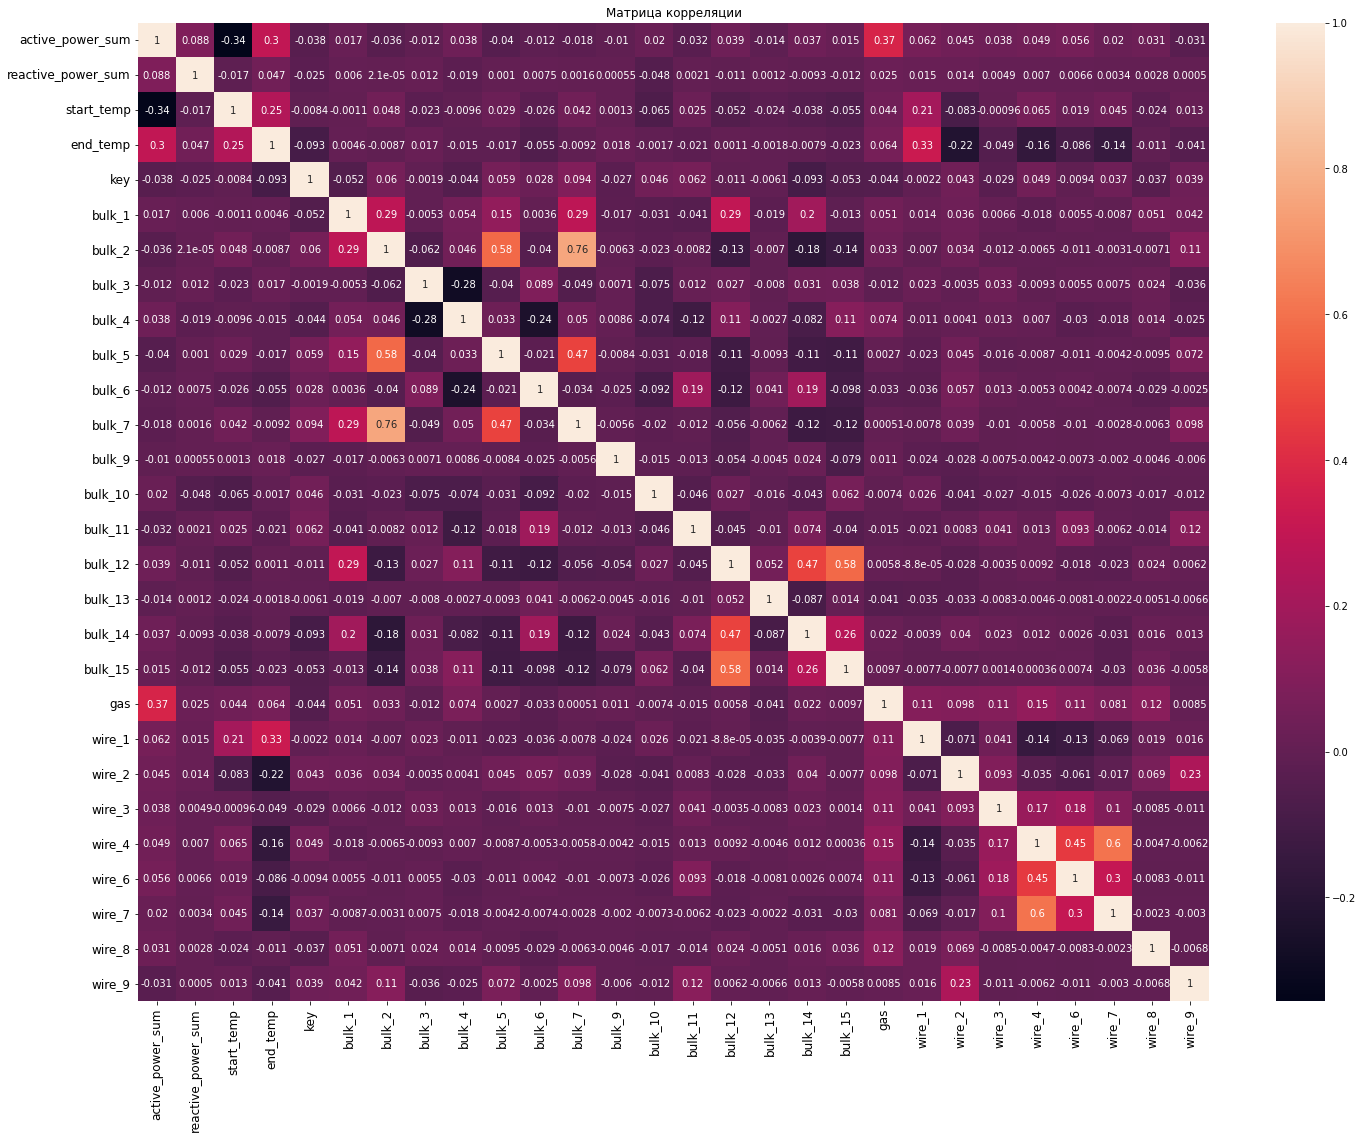

In [ ]:
#посчитаем корреляцияю
plt.figure(figsize=(24,18))
sns.heatmap(data_process.corr(), annot = True, fmt='.2g')
plt.title('Матрица корреляции')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Вывод**

Сильная линейная взаимосвязь наблюдается между следующими величинами:
- bulk_2 и bulk_7(коэффициент корреляции Пирсона — положительный и равер 0.76),
- bulk_12 и bulk_15(коэффициент корреляции Пирсона — положительный и равер 0.58)
- bulk_2 и bulk_5(коэффициент корреляции Пирсона — положительный и равер 0.58)

Так как полной линейной зависимости не наблюдается ни у одной пары величин, принимаем решение не изменять датасет.

Таким образом, наши данные готовы к дальнейшему обучению.



###  Извлечение признаков

In [ ]:
#извлечем признаки
features = data_process.drop(['end_temp'], axis=1) # извлекаем признаки
target = data_process['end_temp'] # извлекаем целевой признак
print(features.shape)
print(target.shape)

(2248, 27)
(2248,)


###  Разделение на выборки

In [ ]:
#разделите данные на обучающую и тестовую выборки 
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25,train_size=0.75, random_state = 171022)
print(features_train.shape)
print(features_test.shape)

(1686, 27)
(562, 27)


### Создание кросс-валидации

In [ ]:
# создадим кросс-валидатор для последующего обучения моделей
cv = KFold(n_splits=3, shuffle=True, random_state=171022)
# словарь для результатов обучения
train_score = {}

##  Обучение моделей

### LightGBM

In [ ]:
lgbm = LGBMRegressor(random_state=171022)
parameters = {'n_estimators': range (10, 101, 10),
#             'max_depth':[5, 10, 15]}
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15]}
gsearch = GridSearchCV(lgbm, parameters, cv=cv,scoring='neg_mean_absolute_error')
gsearch.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=171022, shuffle=True),
             estimator=LGBMRegressor(random_state=171022),
             param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
                         'n_estimators': range(10, 101, 10)},
             scoring='neg_mean_absolute_error')

In [ ]:
best_score = gsearch.best_score_ * (-1)
print("Best score: %0.3f" % best_score)

print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 6.243
Best parameters set:
	learning_rate: 0.05
	n_estimators: 60


In [ ]:
booster = lgb.LGBMModel(objective="regression", n_estimators=60, learning_rate=0.05, random_state=171022)
booster.fit(features_train, target_train)

predicted_train = booster.predict(features_train)


In [ ]:
cv_score = cross_val_score(booster, features_train, target_train, scoring='neg_mean_absolute_error', cv=cv)*(-1)
best_cv_score_lgbm = cv_score.mean()

In [ ]:
train_score['LightGBM'] = [best_cv_score_lgbm]
display(train_score['LightGBM'])

[6.243304826032898]

### LinearRegression

#### Масштабирование признаков

In [ ]:
warnings.filterwarnings('ignore')
#применим метод масштабирования — стандартизация данных
scaler = StandardScaler()
scaler.fit(features_train)
features_train_lr = scaler.transform(features_train)
features_test_lr = scaler.transform(features_test)


In [ ]:
lr_model = LinearRegression()
lr_model.fit(features_train_lr, target_train)

predicted_train = lr_model.predict(features_train_lr)

best_cv_score_lr = cross_val_score(lr_model, features_train_lr, target_train, scoring='neg_mean_absolute_error', cv=cv)*(-1)
best_cv_score_lr = best_cv_score_lr.mean()


In [ ]:
train_score['LinearRegression'] = [best_cv_score_lr]
display(train_score['LinearRegression'])

[8.809713946368282]

###  DecisionTreeRegressor

In [ ]:
dtc = DecisionTreeRegressor(random_state=171022)
parameters = {'max_depth': range (1, 11, 1),
             'min_samples_split': range (2,10,2)}
grid = GridSearchCV(dtc, parameters, cv=cv, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

best_score_dtr = grid.best_score_ *(-1)
print("Best score: %0.3f" % best_score_dtr)

print("Best parameters set:")
best_parameters_dtr = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters_dtr[param_name]))

Best score: 7.133
Best parameters set:
	max_depth: 4
	min_samples_split: 6


In [ ]:
dtc_model = DecisionTreeRegressor(random_state=171022, max_depth=4, min_samples_split=6) # обучим модель с заданной глубиной дерева
dtc_model.fit(features_train,target_train) # обучим модель вызовом метода fit()
    
predicted_train = dtc_model.predict(features_train) # получим предсказания модели

best_cv_score_dtc = cross_val_score(dtc_model, features_train, target_train, scoring='neg_mean_absolute_error', cv=cv)*(-1)
best_cv_score_dtc = best_cv_score_dtc.mean()

train_score['DecisionTreeRegressor'] = [best_cv_score_dtc]
display(train_score['DecisionTreeRegressor'])

[7.133242293715971]

### Анализ полученных моделей

In [ ]:
df_score = pd.DataFrame.from_dict(data = train_score, orient='index', columns=['best_cv_score'])
display(df_score)

,best_cv_score
LightGBM,6.243305
LinearRegression,8.809714
DecisionTreeRegressor,7.133242


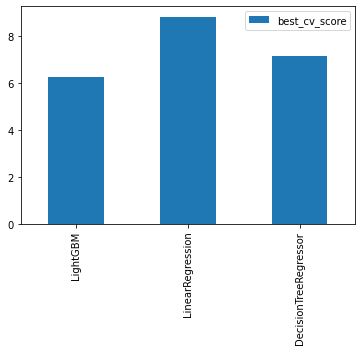

In [ ]:
#для лучшей визуализации, построим графики
df_score.plot(kind="bar", y=['best_cv_score'])


### 3.5 Вывод
Исходя из наших рассчетов, мы можем сделать вывод о том, что в нашем проекте модель LightGBM является лучшей, проверим её на тестовой выборке.


##  Проверка лучшей модели на тестовой выборке

In [ ]:
gsearch.fit(features_test, target_test)

best_score_test = gsearch.best_score_ * (-1)
print("Best score_test: %0.3f" % best_score_test)

booster_test = lgb.LGBMModel(objective="regression", n_estimators=60, learning_rate=0.05, random_state=171022)
booster_test.fit(features_train, target_train)

predicted_test = booster_test.predict(features_test)
mae_test_lgbm = mean_absolute_error(target_test, predicted_test) 

print("MAE наилучшей модели на тестовой выборке:", mae_test_lgbm)

Best score_test: 6.983
MAE наилучшей модели на тестовой выборке: 6.526166919009477


## Проверка модели на адекватность

In [ ]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean").fit(features_train, target_train)

dummy_regr_mean = dummy_regr.predict(features_test)

mae_test_dummy = mean_absolute_error(target_test, dummy_regr_mean) 
print("MAE на тестовой выборке:", mae_test_dummy)

MAE на тестовой выборке: 8.585234060696632


У нашей лучшей модели MAE составила 6.5, у случайной модели - 8.58. Наша модель ведет себя лучше, значит имеет предсказательную силу.

## Итоговый вывод

В ходе работы над данным проектом, были вsполнены все пункты плана. 

При написании кода возникли следующие трудности:
- Был неверно выбран способ построения сводных графиков для пунктов 1.5, 1.6. Графики накладывались друг на друга и провести какой-либо анализ, было сложно. На данную проблему мне указал тимлид и для ее устранения я применила другой способ построения, а именно subplots. Это позволило разместить графики для все столбцов на одной подложке.
- Возникли трудности с определением партий, содержащих данные пригодныедля нашего исследования. Для решения данного вопроса была проведена работа по поиску информации в сети интернет, а также консультации у коллег (одногруппников и знакомых работающих в данной сфере).

Для решения поставленной задачи, были выполнены следующие пункты:
1. Были проанализированны исходные данные, а именно: 
- наименования столбцов приведены к единому виду;
- откорректированы типы данных;
- определено время первого и последнего замера температуры;
- определены начальные и конечные температура сплава;
- определены суммарные значения активной и реактивной мощностей для каждой партии.
2. Полученный после подготовки данных датасет был разделен на обучающую и тестовую выборки в соотношении 3:1. Также был определен целевой признак end_temp. 
3. Для оценки качества работы модели мы использовали кросс-валидацию методом k-Fold(n_splits=3). Данный метод помогает сравнить между собой различные модели и выбрать наилучшую для конкретной задачи.
4. Т.к. мы решаем задачу регрессии, для обучения было выбрано 3 модели:
- LightGBM;
- LinearRegression;
- DecisionTreeRegressor.

Для оценки качества модели мы использовали показатель MAE. Для успешного решения задачи значение MAE должно было составлять не более 6.8.

Для определения верных параметров модели, при которых мы получим лучшую её оценку и эффективность мы использовали компонент GridSearchCV. 

По результатам расчетов, лучшей моделью оказалась LightGBM.
Гиперпараметры лучшей модели:
- n_estimators=60, 
- learning_rate=0.05, 
- random_state=171022.

5. После определения наилучшей модели было проведено тестирование на тестовой выборке. MAE наилучшей модели на тестовой выборке составил 6.52. Это значит, что модель в среднем ошибается на 6-7 градусов.

6. Выполнена проверка на адекватность работы модели с помощью DummyRegressor. Показатель MAE по результатам проверки составил 8.58, что больше значения MAE на тестовой выборке, а значит наша модель является рабочей. 

 

## Итоговый отчет

Вопросы:
   - Какие пункты плана были выполнены, а какие — нет (поясните почему)?
   - Какие трудности возникли и как вы их преодолели?
   - Какие ключевые шаги в решении задачи выделили?
   - Какая ваша итоговая модель и какое у неё качество?

В ходе работы над данным проектом, были вsполнены все пункты плана. 

При написании кода возникли следующие трудности:
- Был неверно выбран способ построения сводных графиков для пунктов 1.5, 1.6. Графики накладывались друг на друга и провести какой-либо анализ, было сложно. На данную проблему мне указал тимлид и для ее устранения я применила другой способ построения, а именно subplots. Это позволило разместить графики для все столбцов на одной подложке.
- Возникли трудности с определением партий, содержащих данные пригодныедля нашего исследования. Для решения данного вопроса была проведена работа по поиску информации в сети интернет, а также консультации у коллег (одногруппников и знакомых работающих в данной сфере).

Для решения поставленной задачи, были выполнены следующие пункты:
1. Были **проанализированны исходные данные**, а именно: 

- *Наименования столбцов приведены к единому стилю*.

Все наименования записаны нижним регистром на английском языке, пробелы заменены нижним подчеркиванием.;

- *Откорректированы типы данных*.

Столбцы содержащие данные о времени приведны к типу данных date64, столбцы содержащие информацию о подаче сыпучих и проволочных материалов в формат float(числа с плавающей запятой), значения партий и температур, начальной и конечной, в формат целых чисел int.;

- *Определено время первого и последнего замера температуры.* 

Для этого из датасета data_temp(результаты измерения температур) были удалены партии, в которых отсутстует последний замер времени(т.е. последний замер конечной температуры произошел раньше, чем последний замер температуры нагрева электродом), а также значения которые имели только одно значение (начальное время замера, равно конечной) Таким образом, мы получили временные значения первого и последнего замера и поместили их в отдельную таблицу temp_time;

- *Определены начальные и конечные температура сплава.*

Для решения данной задачи мы использовали полученную таблицу temp_time и датасет data_temp. С помощью полученных значений времени, мы смогли получить температуры соответсвующие первому и последнему измерению температур;

- *Определены суммарные значения активной и реактивной мощностей для каждой партии*.

Определены полная реактивная и активная мощности для каждой партии. Для этого получено суммарное значение для каждого вида энергии. Полученные данные занесены в отдельную таблицу power_sum.

- *Полученные данные были объедены в итоговый датасет*.

В итоговую таблицу вошли следующие данные:
- суммарные значения мощностей;
- начальная и конечная температуры сплава;
- данные о подаче сыпучих материалов;
- данные о продувке сплава газом;
- данные о подаче проволочных материалов.

Данные были объедены способом объединения строк из нескольких таблиц join ="inner". Это объединение, когда выводятся все записи из одной таблицы и все соответствующие записи из другой таблицы, т.е. только те записи которые соответствуют ключу. В нашем случае ключем являлся номер партии.

После получения итоговой таблицы, было принято решение удалить два столбца, в которых содержалась только 1 запись. Это столбцы 'wire_5', 'bulk_8'. 

Также все значения NaN были заменены на 0. Такое решение было принято, так как значения NaN в нашем случае, считается отсутствием данного этапа в технологическом процессе.


2. Полученный после подготовки данных **датасет был разделен на обучающую и тестовую выборки** в соотношении 3:1. Также был определен целевой признак end_temp. 

3. **Для оценки качества работы модели мы использовали кросс-валидацию** методом k-Fold(n_splits=3). Данный метод помогает сравнить между собой различные модели и выбрать наилучшую для конкретной задачи.

4. Т.к. мы решаем задачу регрессии, **для обучения было выбрано 3 модели**:
- LightGBM;
- LinearRegression;
- DecisionTreeRegressor.

Для определения параметров модели, при которых мы получим лучшую её оценку и эффективность мы использовали компонент GridSearchCV. 

При обучении модели мы использовали перекрестную проверку. Для оценки модели мы использовали метрику регрессии ‘neg_mean_absolute_error’. Функция вычисляет среднюю абсолютную ошибку и представляет собой сумму ‘абсолютных различий’ между прогнозируемыми и фактическими значениями.

Для успешного решения задачи значение MAE должно было составлять не более 6.8.

По результатам расчетов, лучшей моделью оказалась LightGBM. Значения MAE по расчетам для этой модели составило 6.24( данные вы можете наблюдать в таблице, а для большей наглядности на графике).

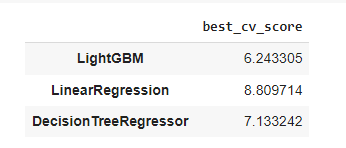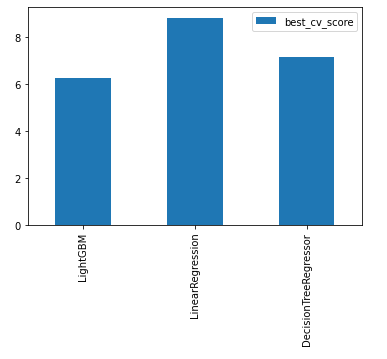

**Гиперпараметры лучшей модели**:

- n_estimators=60 

Количество базовых оценщиков. Этот параметр монотонно влияет на точность модели. Чем больше n_estimators, тем лучше эффект модели. Но, соответственно, любая модель имеет границу принятия решения.После того, как n_estimators достигают определенного уровня, точность модели часто не повышается или не начинает колебаться;

- learning_rate=0.05

Этот параметр используется для определения скорости обучения;

- random_state=171022

Генерируемые псевдослучайные величины будут иметь одни и те же значения при каждом вызове.

5. После определения наилучшей модели было проведено тестирование на тестовой выборке. MAE наилучшей модели на тестовой выборке составил 6.52. Это значит, что модель в среднем ошибается на 6-7 градусов.

6. Выполнена проверка на адекватность работы модели с помощью DummyRegressor. Показатель MAE по результатам проверки составил 8.58, что больше значения MAE на тестовой выборке, а значит наша модель является рабочей. 

 